# Bayesian Ridge Regression

# References 

* http://www.machinelearning.org/proceedings/icml2004/papers/354.pdf
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information matplotlib, numpy, pandas, pymc3, seaborn, sklearn, theano

Software,Version
Python,3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,4.1.2
OS,Linux 3.13.0 86 generic x86_64 with debian jessie sid
matplotlib,1.5.1
numpy,1.10.4
pandas,0.18.0
pymc3,3.0
seaborn,0.7.0
sklearn,0.17.1
theano,0.9.0dev1.dev-5e50147375ad507990655cc1a3e990aa4c190549


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import random
import seaborn as sns
from sklearn import preprocessing as preproc
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae
import theano
from theano import tensor as T

#pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)
sns.set()

In [3]:
path = '../btc-data/BTC_LOB_features_10s.csv'
data10s = pd.read_csv(path, index_col = 0, parse_dates = True)

In [4]:
data30s = data10s.reindex(pd.date_range(start = data10s.index[0], end = data10s.index[-1], freq='30s'))
data1m = data10s.reindex(pd.date_range(start = data10s.index[0], end = data10s.index[-1], freq='60s'))
data5m = data10s.reindex(pd.date_range(start = data10s.index[0], end = data10s.index[-1], freq='300s'))
data10m = data10s.reindex(pd.date_range(start = data10s.index[0], end = data10s.index[-1], freq='600s'))

datas = [data10s, data30s, data1m, data5m, data10m]

# Data Preprocessing

In [5]:
def evaluate(data):
    
    X, y = data, data['mid price'].copy()

    for df in X.columns.tolist():
        X[df] = preproc.StandardScaler().fit(X[df].reshape(-1,1)).transform(X[df].reshape(-1,1))

    train_dates = X.index[:int(0.7*len(X))]
    test_dates = X.index[int(0.7*len(X)):]

    #X_train[train_dates[0] : train_dates[-361]] = [X[i : i + 360] for i in range(len(X[:-360]))]
    #X_test = X[test_dates[0] : test_dates[-361]]
    #y_train = y[train_dates[360] : train_dates[-1]]
    #y_test = y[test_dates[360] : test_dates[-361]]

    print('First training date: ', train_dates[0])
    print('Last training date: ', train_dates[-1])
    print('First testing date: ', test_dates[0])
    print('Last testing date: ', test_dates[-1])

    # Create DataFrames for the training set. Input: mid prices from the previous hour, output: mid price change in the next 10 seconds.

    X_train = pd.DataFrame()
    y_train = y[train_dates[360] : train_dates[-1]]

    for i in range(360):
        colname = 'mid price ' + str(i + 1)
        X_train[colname] = X['mid price'].ix[i : (len(train_dates) + i - 360)].values

    X_train.set_index(train_dates[360:], inplace = True)

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20, 10))
    plt.title("Weights of the previous prices")
    plt.plot(clf.coef_)
    plt.xlabel("Prices")
    plt.ylabel("Weights")

    X_test = pd.DataFrame()
    y_test = y[test_dates[360] : test_dates[-1]]

    for i in range(360):
        colname = 'mid price ' + str(i + 1)
        X_test[colname] = X['mid price'].ix[(i + len(train_dates)) : (len(train_dates) + len(test_dates) + i - 360)].values

    X_test.set_index(test_dates[360:], inplace = True)

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates[360:])

    plt.figure(figsize = (20,10))
    plt.title('Prediction with previous 360 prices')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.legend()

    plt.figure(figsize = (20,10))
    plt.title('Zoom in')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-08 19', '2016-04-08 20:30')
    plt.ylim(416.3, 424.1)
    plt.legend()
    
    print('\n\nResults of prediction with previous 360 prices')
    print('==============================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    accuracy = np.sum(act_pred_cmp) / len(act_ticks)
    print('Directional Symmetry: ', accuracy, '\n')
    print('==============================================\n\n')

    for c in X.drop('mid price', axis = 1).columns.tolist():
        for i in range(2):
            colname = c + ' ' + str(i + 1)
            X_train[colname] = X[c].ix[358 + i : len(train_dates) + i - 2].values

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20,10))
    plt.title("Weights of the features and previous prices")
    plt.plot(clf.coef_)
    plt.xlabel("Features")
    plt.xlim(350, 383)
    plt.ylabel("Weights")

    for c in X.drop('mid price', axis = 1).columns.tolist():
        for i in range(2):
            colname = c + ' ' + str(i + 1)
            X_test[colname] = X[c].ix[len(train_dates) + 358 + i : len(train_dates) + len(test_dates) + i - 2].values

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates[360:])

    plt.figure(figsize = (20,10))
    plt.title('Prediction with features and prices')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-08 19', '2016-04-08 20')
    plt.ylim(416.3, 424.1)
    plt.legend()

    print('Results of prediction with previous 360 prices and previous 2 features')
    print('======================================================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    accuracy = np.sum(act_pred_cmp) / len(act_ticks)
    print('Directional Symmetry: ', accuracy, '\n')
    print('======================================================================\n\n')

    X_train = pd.DataFrame()
    y_train = y[train_dates[2] : train_dates[-1]]
    
    for i in range(2):
        colname = 'mid price ' + str(i + 1)
        X_train[colname] = X['mid price'].ix[i : (len(train_dates) + i - 2)].values
    
    for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
        X_train[c] = X[c].ix[1 : len(train_dates) - 1].values
    
    X_train.set_index(train_dates[2:], inplace = True)

    X_test = pd.DataFrame()
    y_test = y[test_dates[2] : test_dates[-1]]

    for i in range(2):
        colname = 'mid price ' + str(i + 1)
        X_test[colname] = X['mid price'].ix[(i + len(train_dates)) : (len(train_dates) + len(test_dates) + i - 2)].values
    
    for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
        X_test[c] = X[c].ix[len(train_dates) + 1 : len(train_dates) + len(test_dates) - 1].values
            
    X_test.set_index(test_dates[2:], inplace = True)

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates[2:])

    print('Results of prediction with previous 2 prices and selected features')
    print('=========================================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    accuracy = np.sum(act_pred_cmp) / len(act_ticks)
    print('Directional Symmetry: ', accuracy, '\n')
    print('=========================================================\n\n')

First training date:  2016-01-01 00:00:00
Last training date:  2016-03-25 17:29:50
First testing date:  2016-03-25 17:30:00
Last testing date:  2016-05-01 00:59:50


Results of prediction with previous 360 prices

Training set R2:  0.999967909014 , Test set R2:  0.999962361426
Training set RMSE:  0.129202324923 , Test set RMSE:  0.093629886478
Training set MAE:  0.0442049656069 , Test set MAE:  0.0249977581321
Directional Symmetry:  0.526292444612 



Results of prediction with previous 360 prices and previous 2 features

Training set R2:  0.999968797544 , Test set R2:  0.999962393608
Training set RMSE:  0.127401102551 , Test set RMSE:  0.0935898497919
Training set MAE:  0.0506963761502 , Test set MAE:  0.0339535363028
Directional Symmetry:  0.515854604169 



Results of prediction with previous 2 prices and selected features

Training set R2:  0.999968209664 , Test set R2:  0.999962401765
Training set RMSE:  0.128594827146 , Test set RMSE:  0.093574490329
Training set MAE:  0.04860070

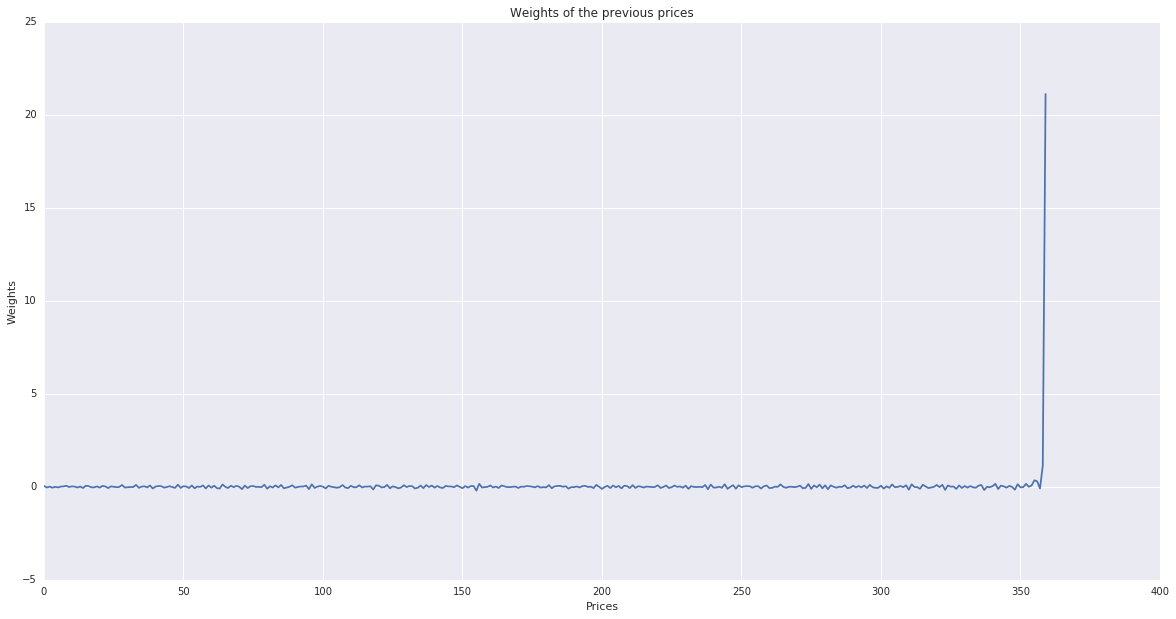

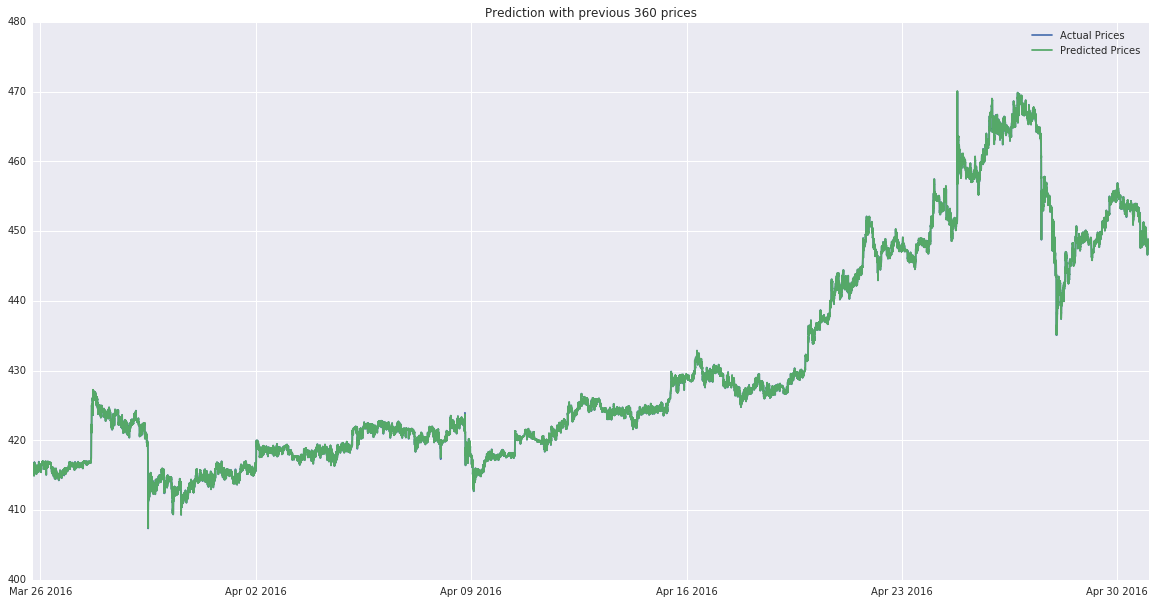

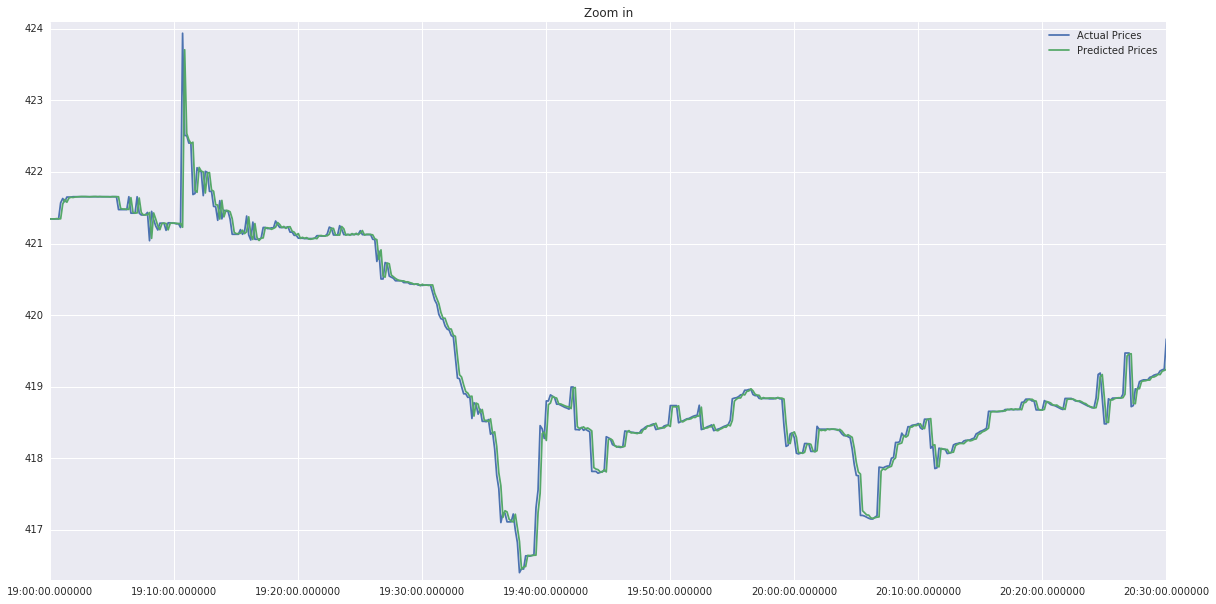

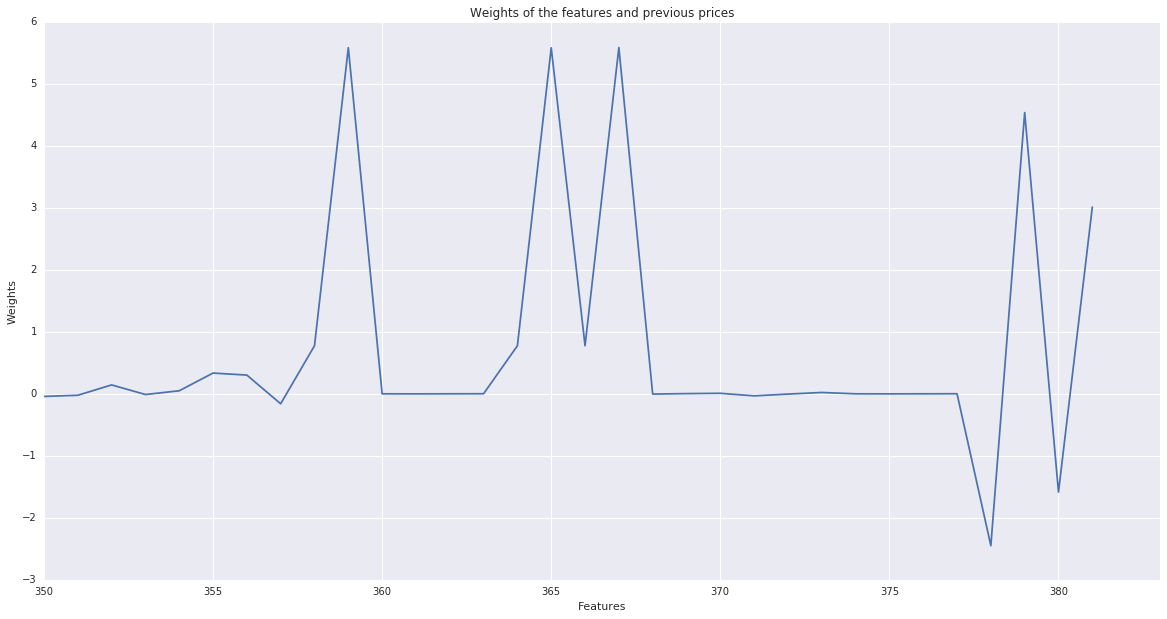

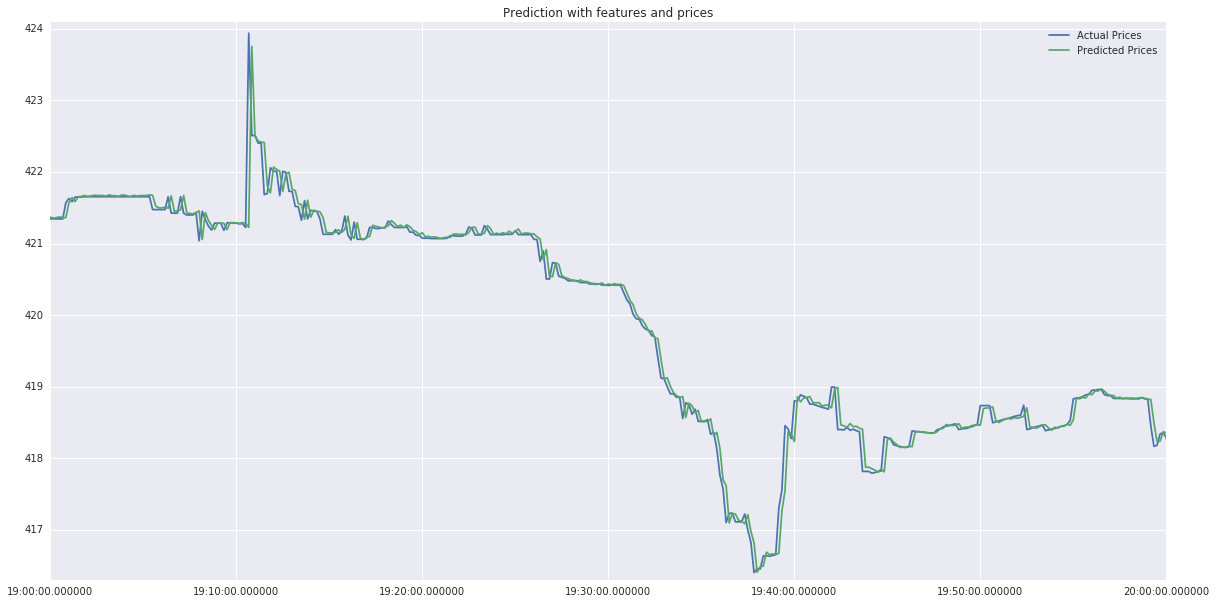

In [6]:
evaluate(datas[0].copy())

First training date:  2016-01-01 00:00:00
Last training date:  2016-03-25 17:29:00
First testing date:  2016-03-25 17:29:30
Last testing date:  2016-05-01 00:59:30


Results of prediction with previous 360 prices

Training set R2:  0.999916024683 , Test set R2:  0.999898253841
Training set RMSE:  0.209014342307 , Test set RMSE:  0.153960786804
Training set MAE:  0.093783605256 , Test set MAE:  0.0563133070321
Directional Symmetry:  0.51858568413 



Results of prediction with previous 360 prices and previous 2 features

Training set R2:  0.999920823179 , Test set R2:  0.999900289777
Training set RMSE:  0.202954783142 , Test set RMSE:  0.152412628992
Training set MAE:  0.103457939522 , Test set MAE:  0.0718135892003
Directional Symmetry:  0.508453271925 



Results of prediction with previous 2 prices and selected features

Training set R2:  0.99991769319 , Test set R2:  0.999899575466
Training set RMSE:  0.206916483444 , Test set RMSE:  0.152929179649
Training set MAE:  0.100915964333 

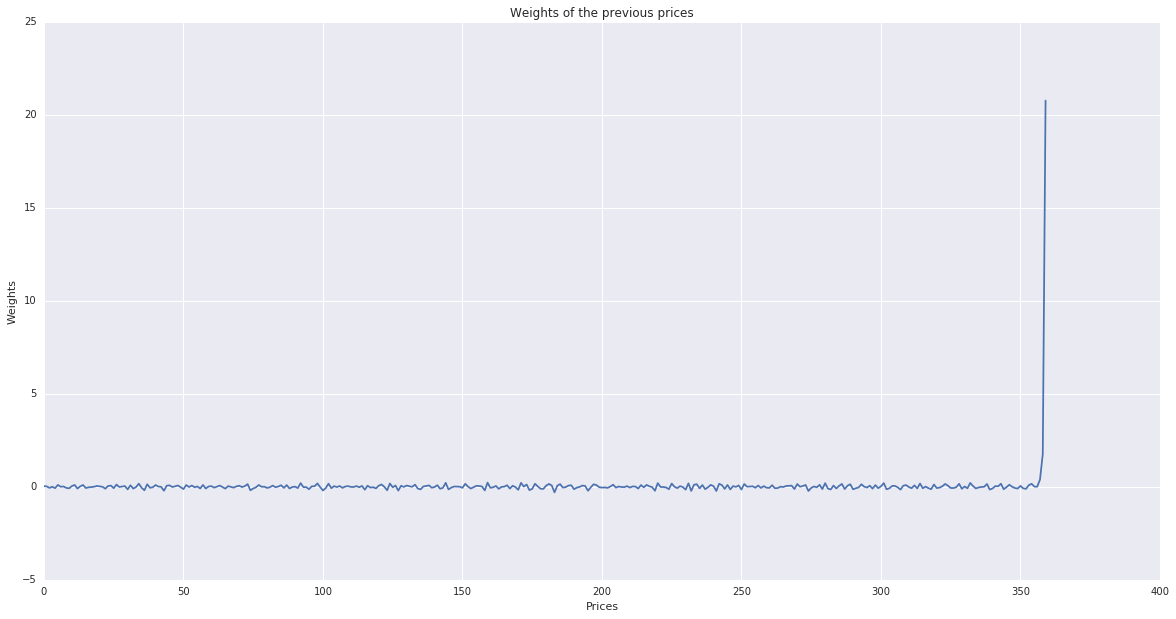

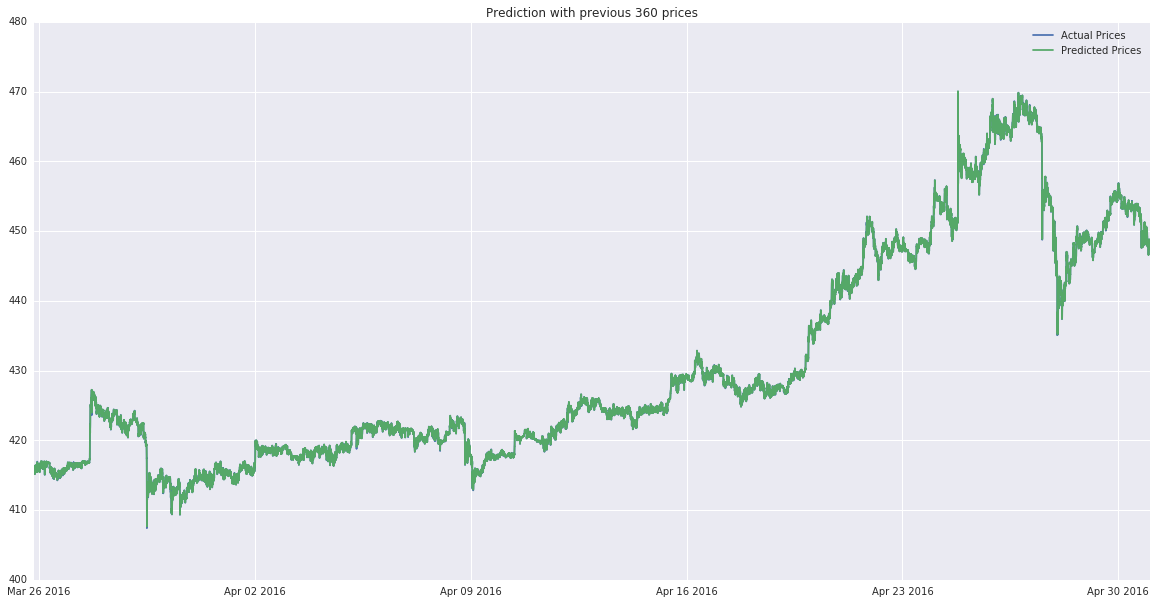

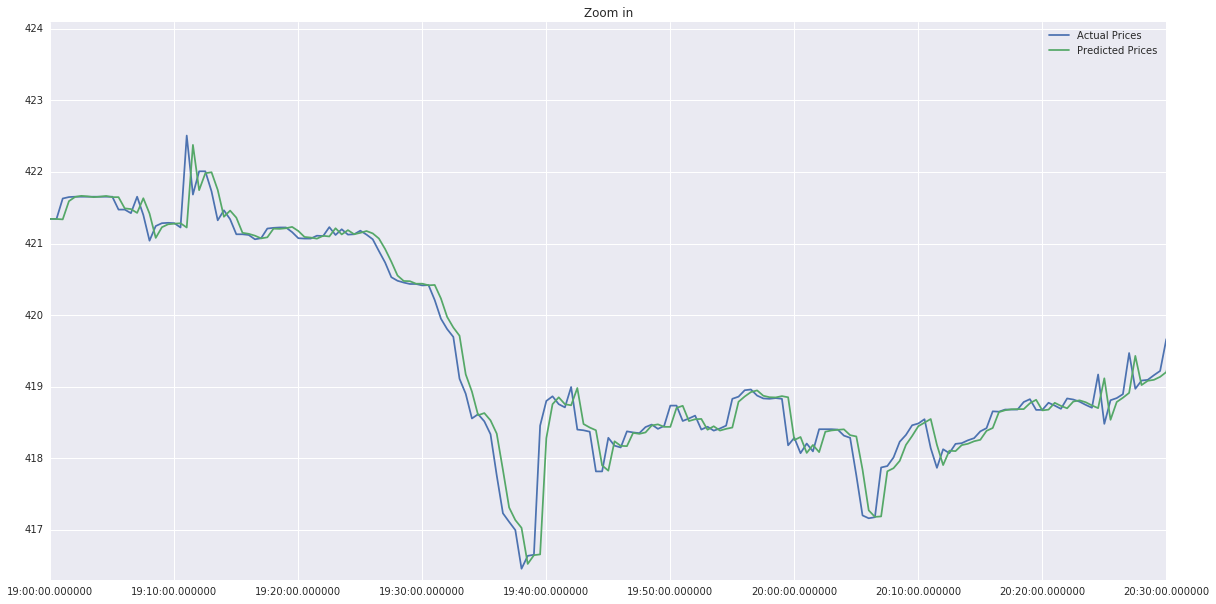

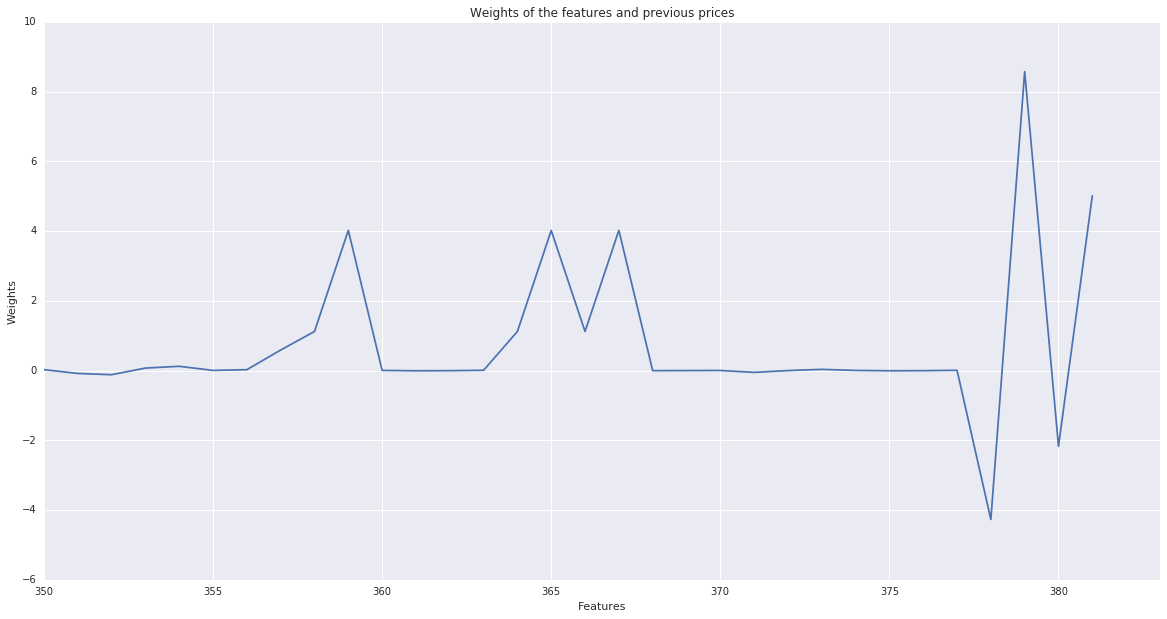

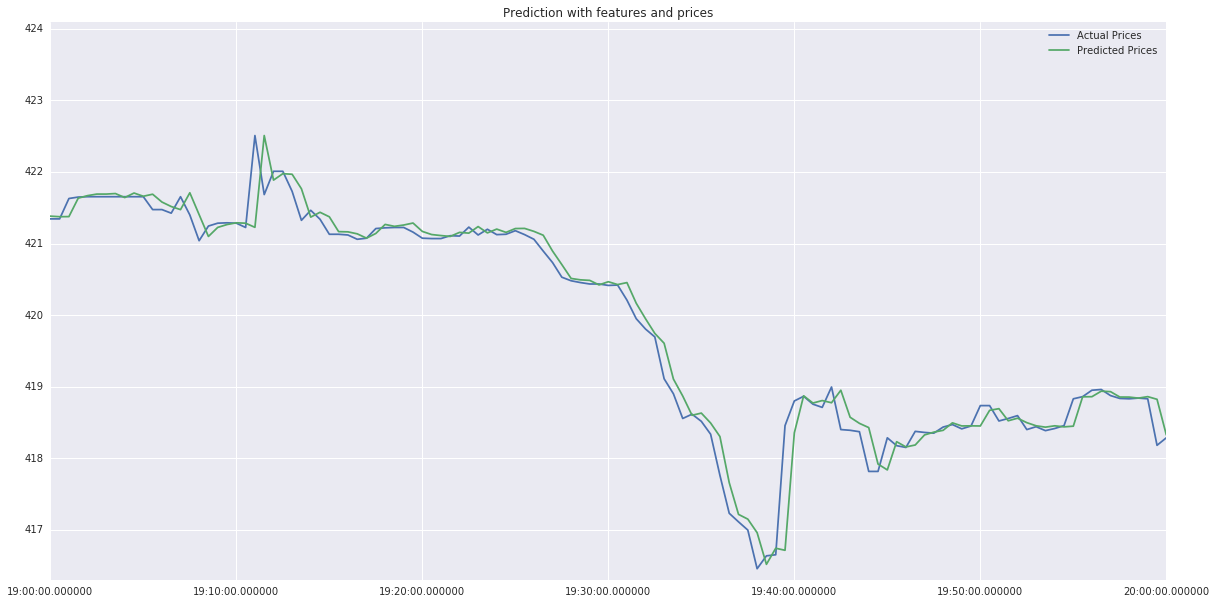

In [7]:
evaluate(datas[1].copy())

First training date:  2016-01-01 00:00:00
Last training date:  2016-03-25 17:28:00
First testing date:  2016-03-25 17:29:00
Last testing date:  2016-05-01 00:59:00


Results of prediction with previous 360 prices

Training set R2:  0.999849672384 , Test set R2:  0.999806979746
Training set RMSE:  0.279609602266 , Test set RMSE:  0.212089104692
Training set MAE:  0.141683393387 , Test set MAE:  0.089039244156
Directional Symmetry:  0.508222607356 



Results of prediction with previous 360 prices and previous 2 features

Training set R2:  0.99986121149 , Test set R2:  0.999814608504
Training set RMSE:  0.268663985779 , Test set RMSE:  0.207855644107
Training set MAE:  0.151025740593 , Test set MAE:  0.107227172546
Directional Symmetry:  0.505411130368 



Results of prediction with previous 2 prices and selected features

Training set R2:  0.999853467653 , Test set R2:  0.999812540206
Training set RMSE:  0.276080849454 , Test set RMSE:  0.20894348593
Training set MAE:  0.149409972943 , 

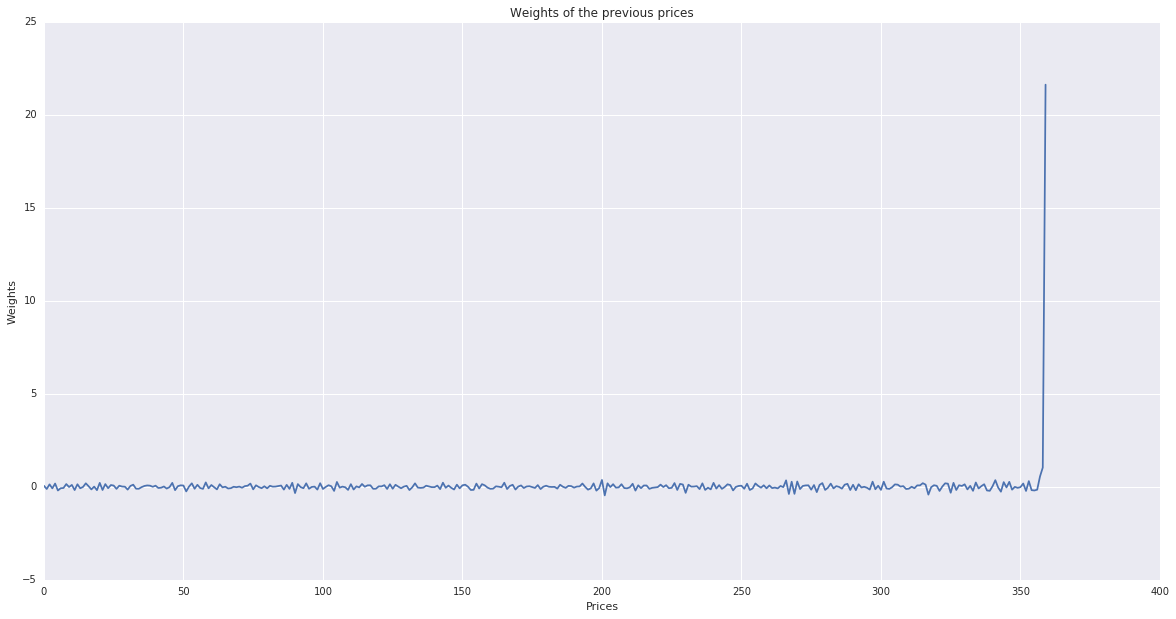

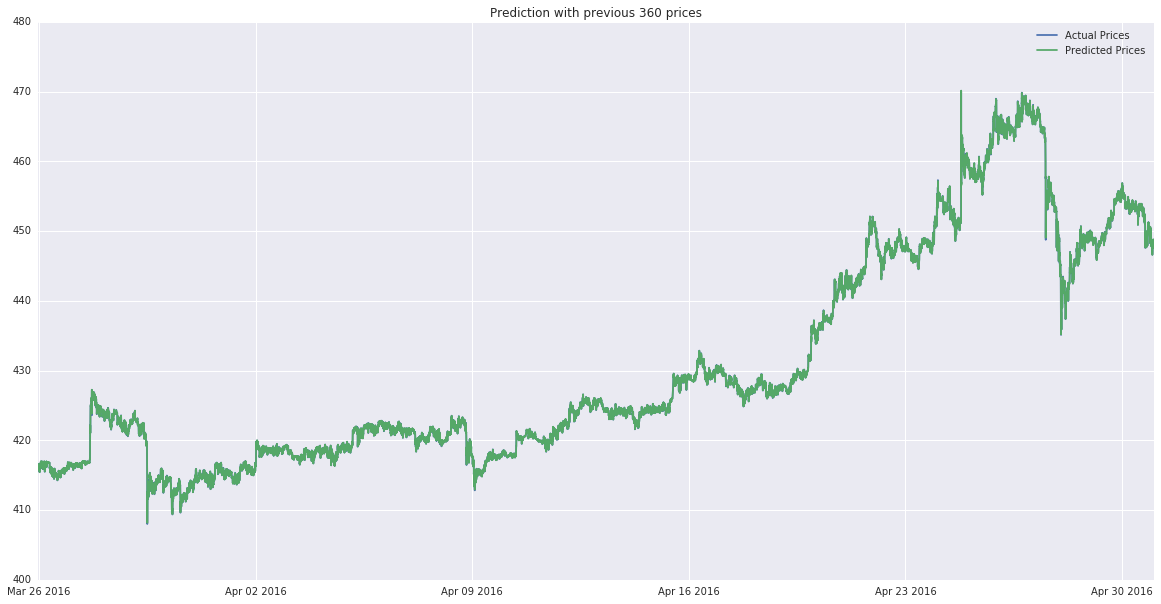

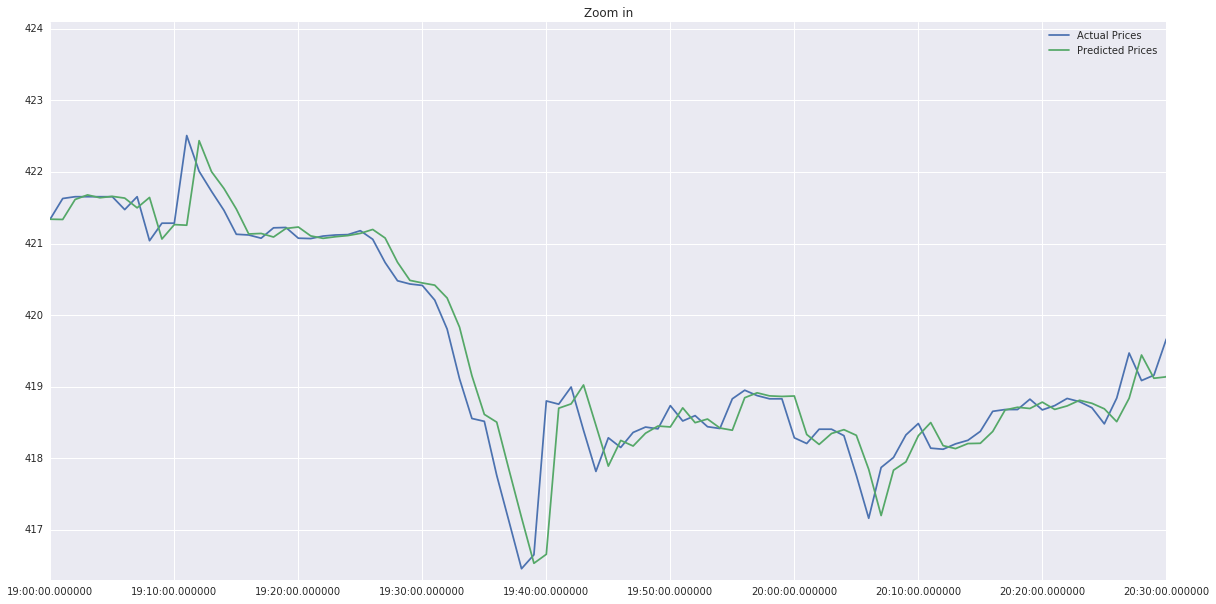

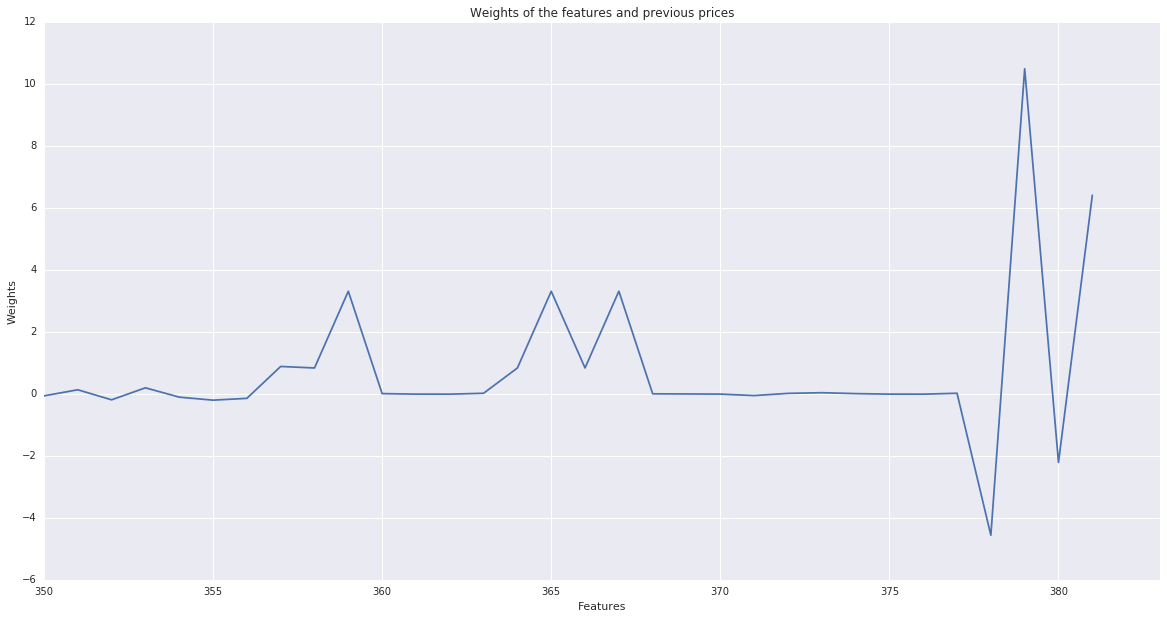

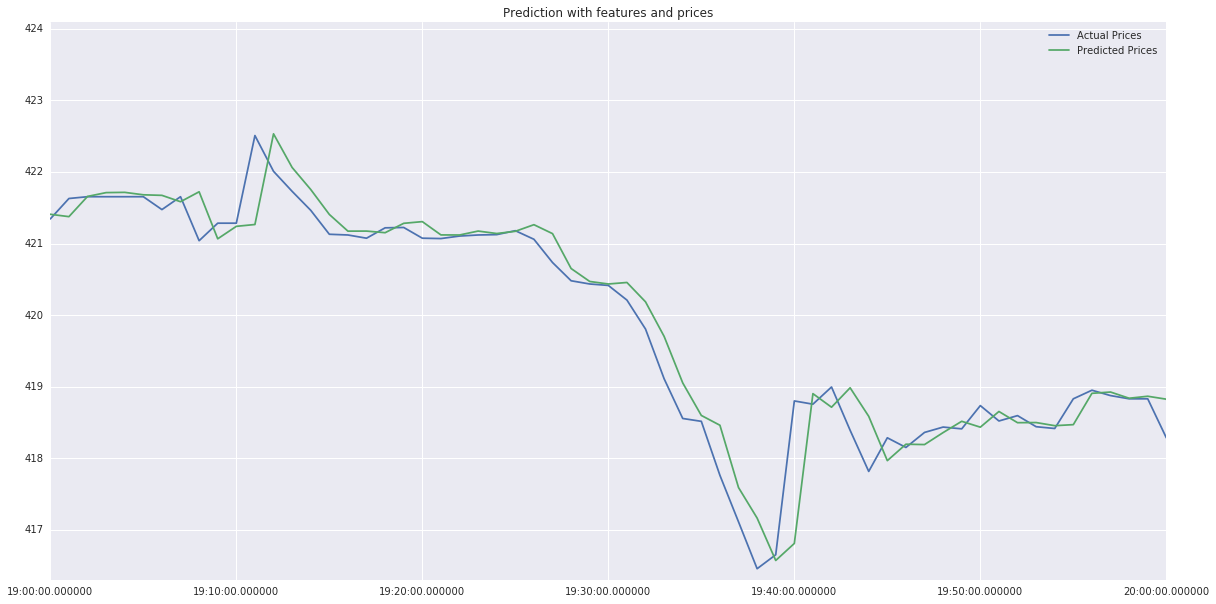

In [8]:
evaluate(datas[2].copy())

First training date:  2016-01-01 00:00:00
Last training date:  2016-03-25 17:25:00
First testing date:  2016-03-25 17:30:00
Last testing date:  2016-05-01 00:55:00


Results of prediction with previous 360 prices

Training set R2:  0.999340114704 , Test set R2:  0.999124335039
Training set RMSE:  0.585343366389 , Test set RMSE:  0.452072007608
Training set MAE:  0.347467992544 , Test set MAE:  0.238097137994
Directional Symmetry:  0.471229077944 



Results of prediction with previous 360 prices and previous 2 features

Training set R2:  0.999376560361 , Test set R2:  0.999172829502
Training set RMSE:  0.568949448849 , Test set RMSE:  0.439375815457
Training set MAE:  0.341680350522 , Test set MAE:  0.241601207436
Directional Symmetry:  0.48578785778 



Results of prediction with previous 2 prices and selected features

Training set R2:  0.999344736083 , Test set R2:  0.99918443308
Training set RMSE:  0.583817835395 , Test set RMSE:  0.435808486497
Training set MAE:  0.344296679285 , 

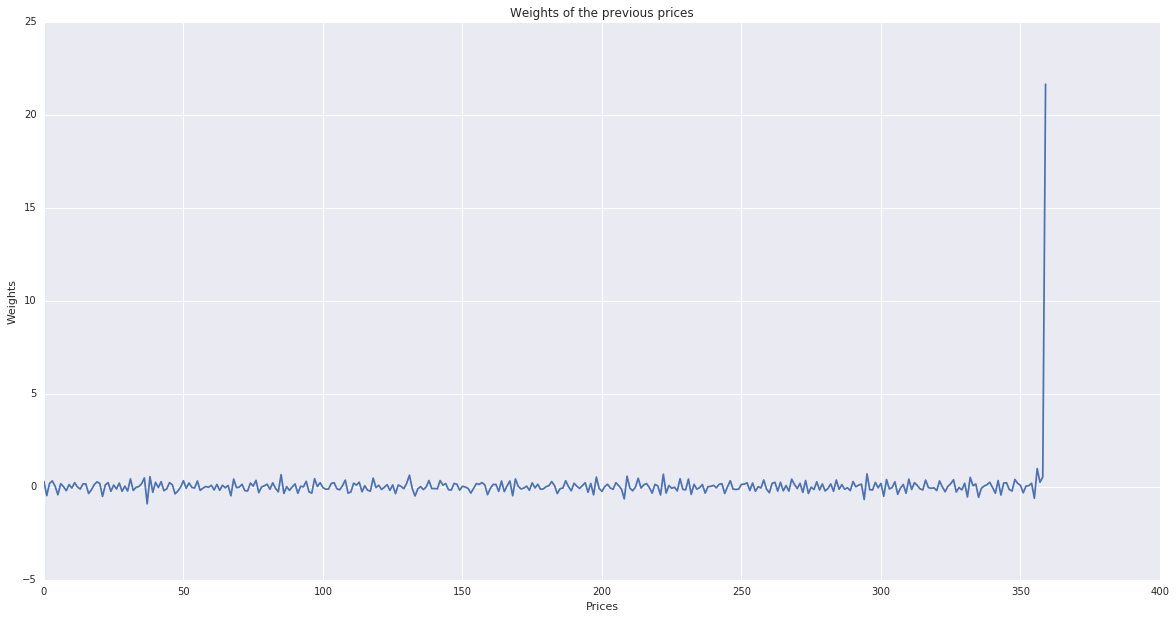

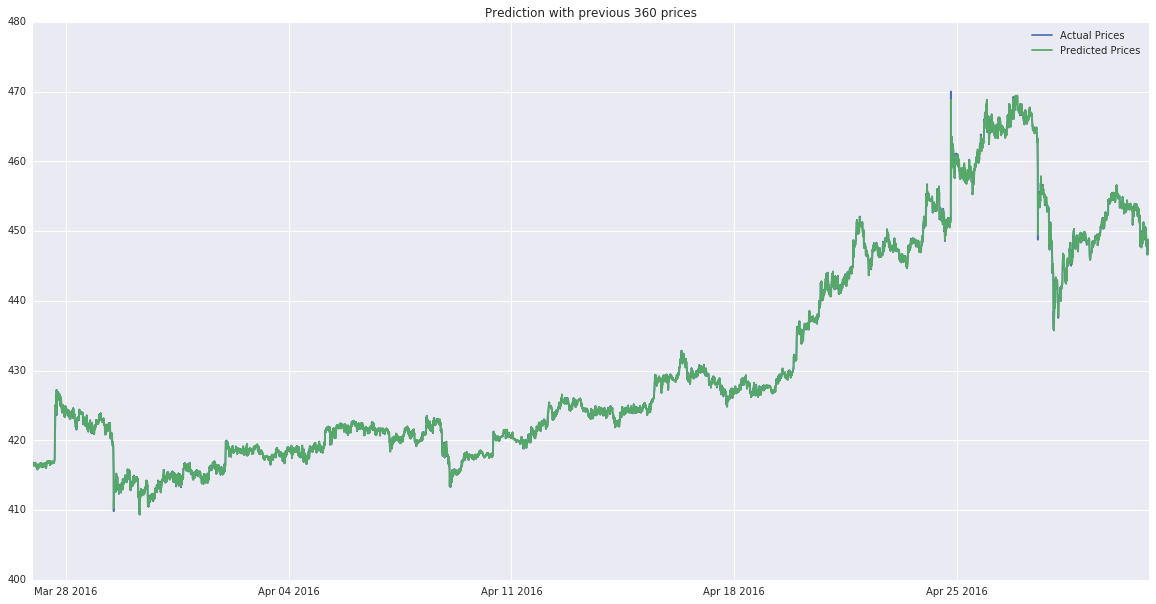

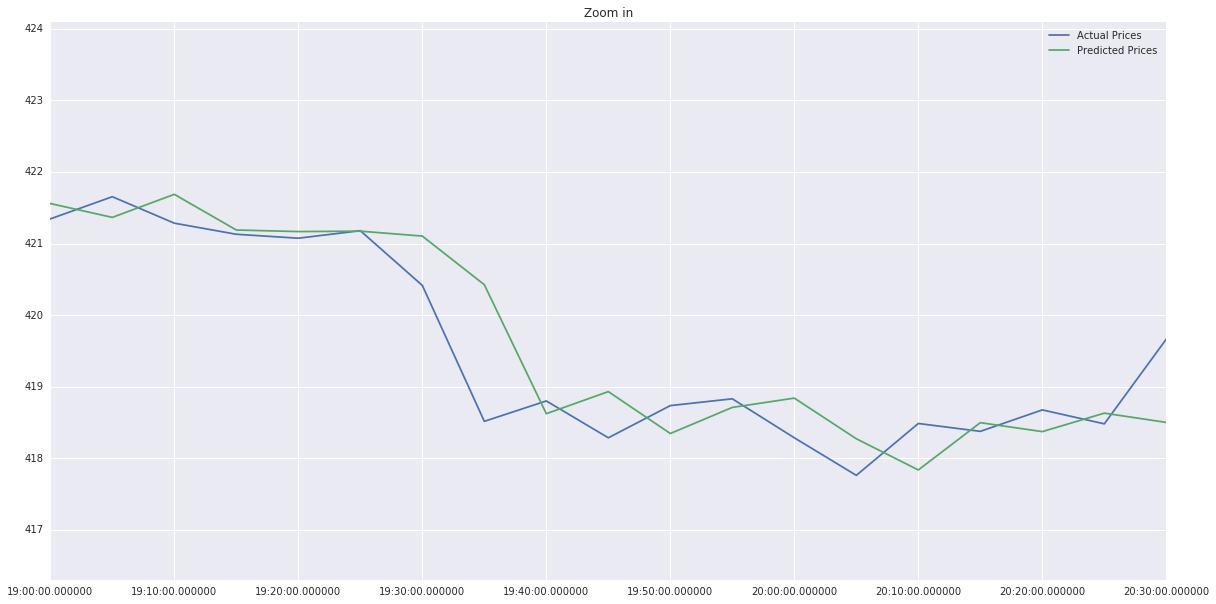

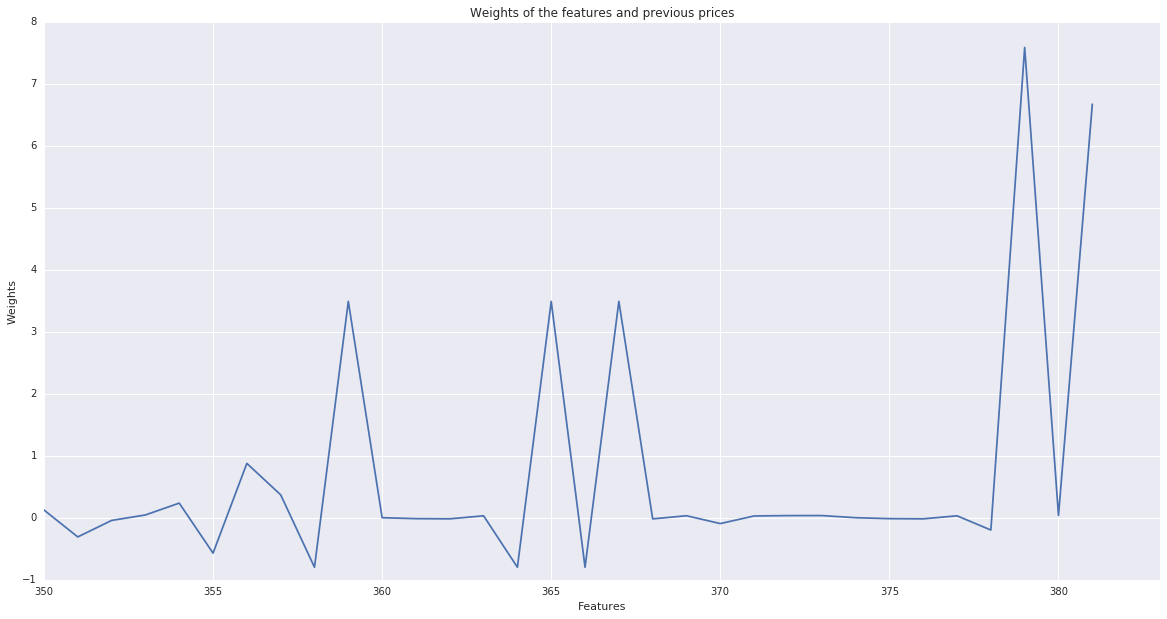

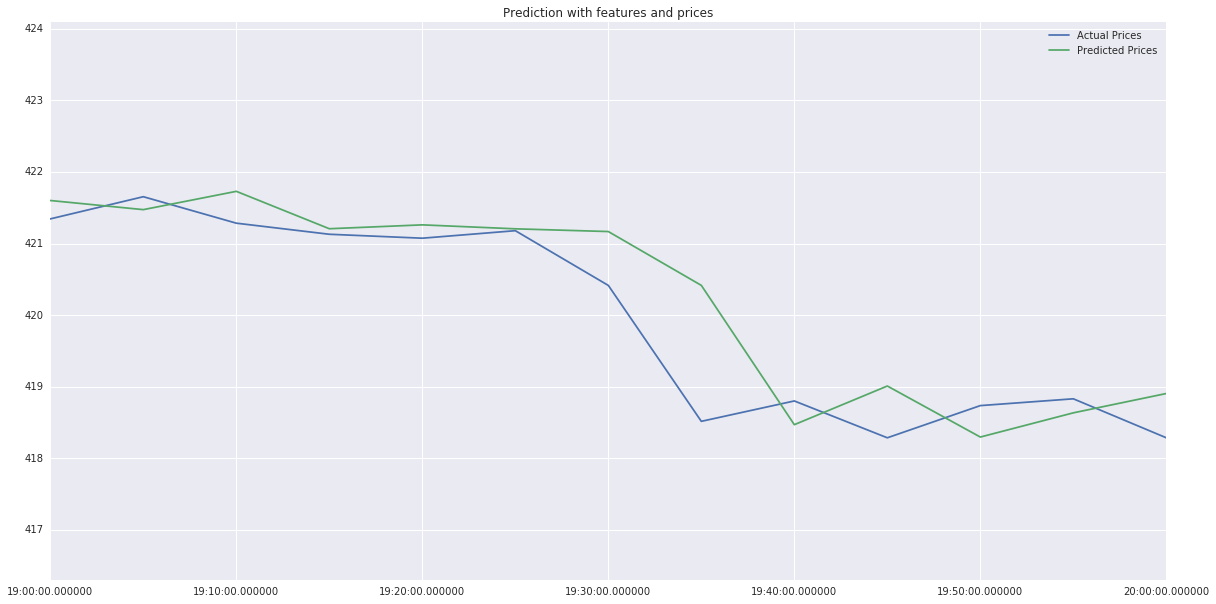

In [9]:
evaluate(datas[3].copy())

First training date:  2016-01-01 00:00:00
Last training date:  2016-03-25 17:20:00
First testing date:  2016-03-25 17:30:00
Last testing date:  2016-05-01 00:50:00


Results of prediction with previous 360 prices

Training set R2:  0.998734179748 , Test set R2:  0.998752233311
Training set RMSE:  0.809928566353 , Test set RMSE:  0.543616398657
Training set MAE:  0.497557819 , Test set MAE:  0.330143820754
Directional Symmetry:  0.463434675431 



Results of prediction with previous 360 prices and previous 2 features

Training set R2:  0.99877640279 , Test set R2:  0.99880017656
Training set RMSE:  0.796305904734 , Test set RMSE:  0.533070349105
Training set MAE:  0.486867332434 , Test set MAE:  0.328752164283
Directional Symmetry:  0.472678718159 



Results of prediction with previous 2 prices and selected features

Training set R2:  0.998720645572 , Test set R2:  0.998849876746
Training set RMSE:  0.815592030353 , Test set RMSE:  0.517280060544
Training set MAE:  0.485173375639 , Tes

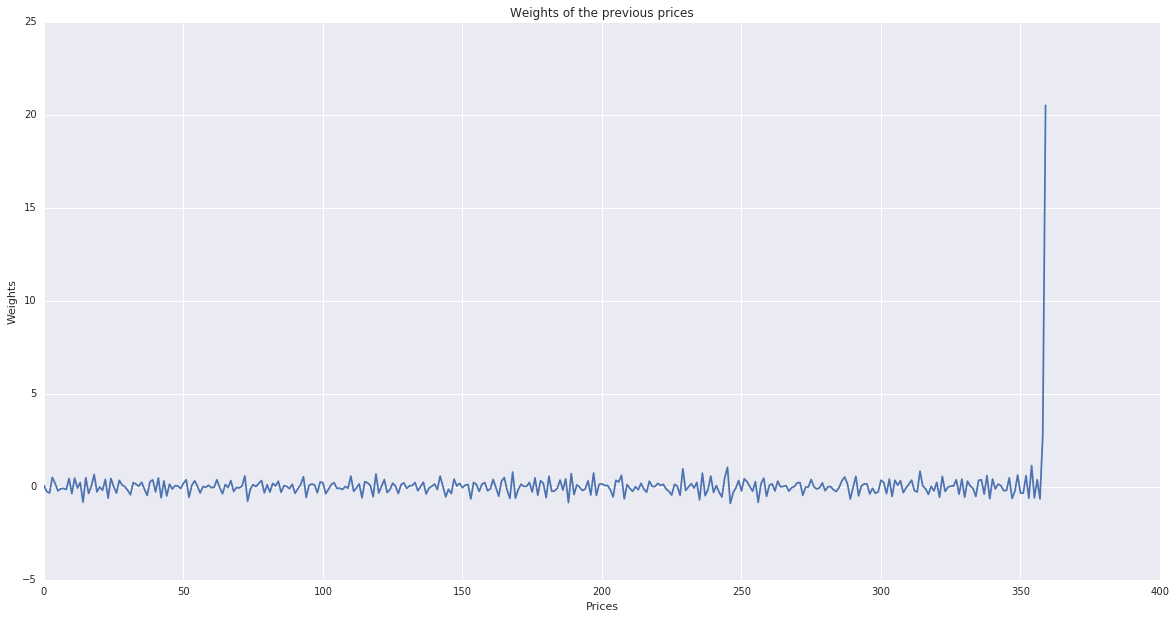

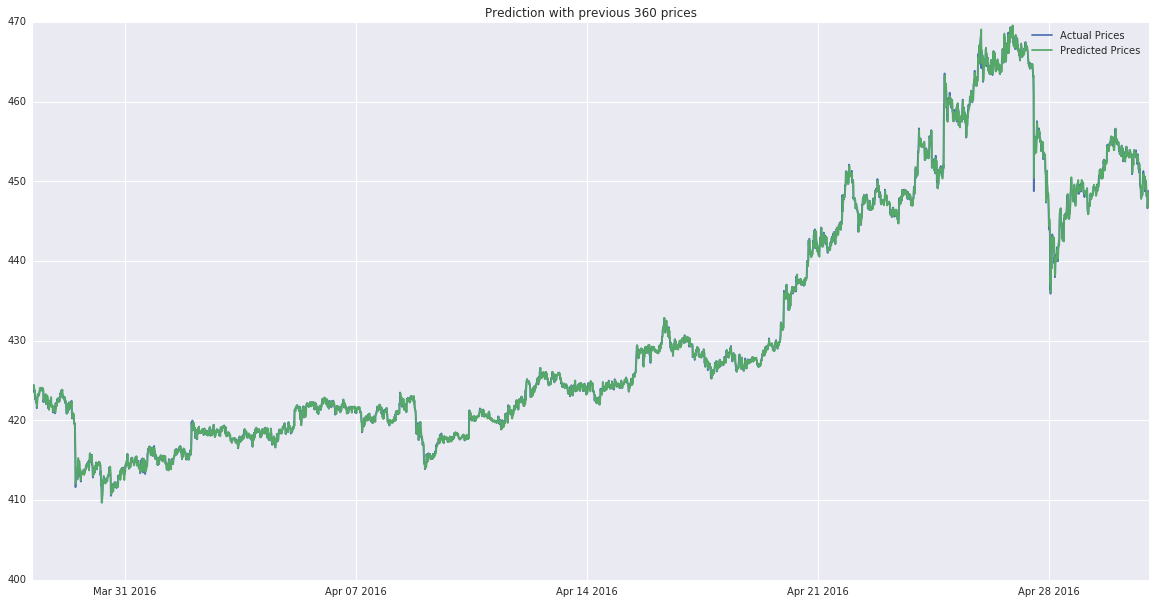

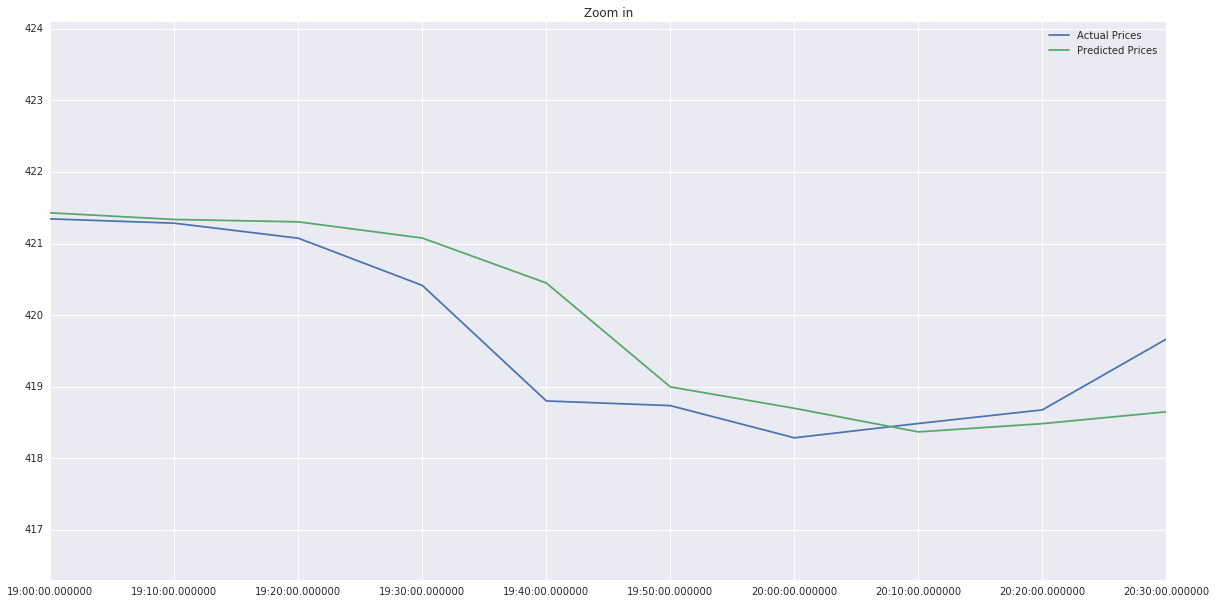

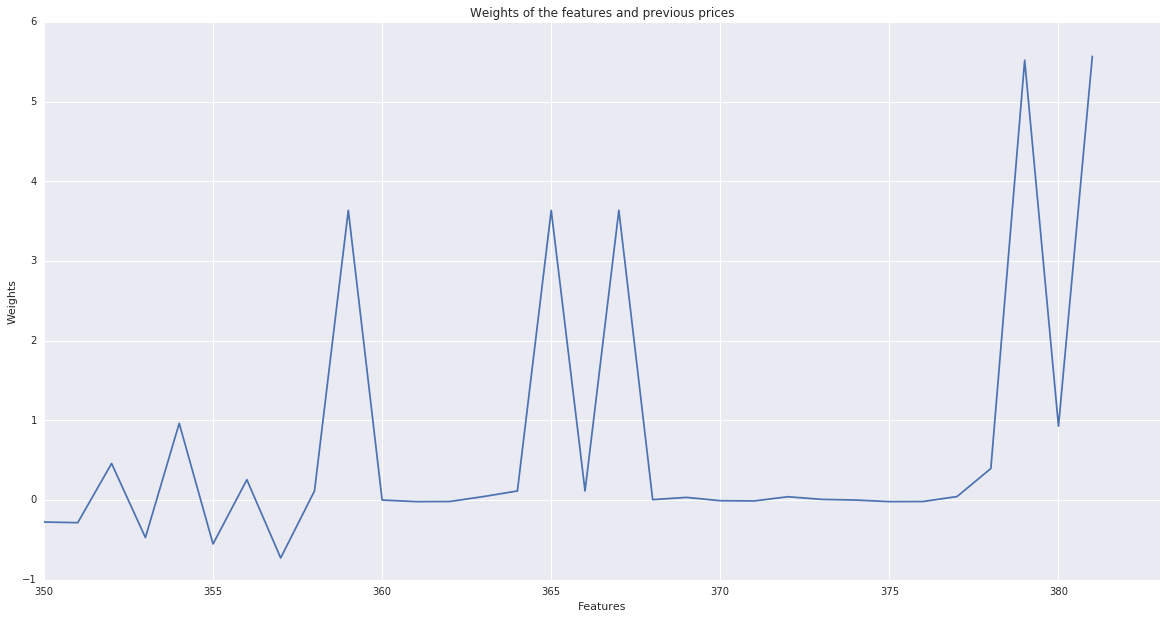

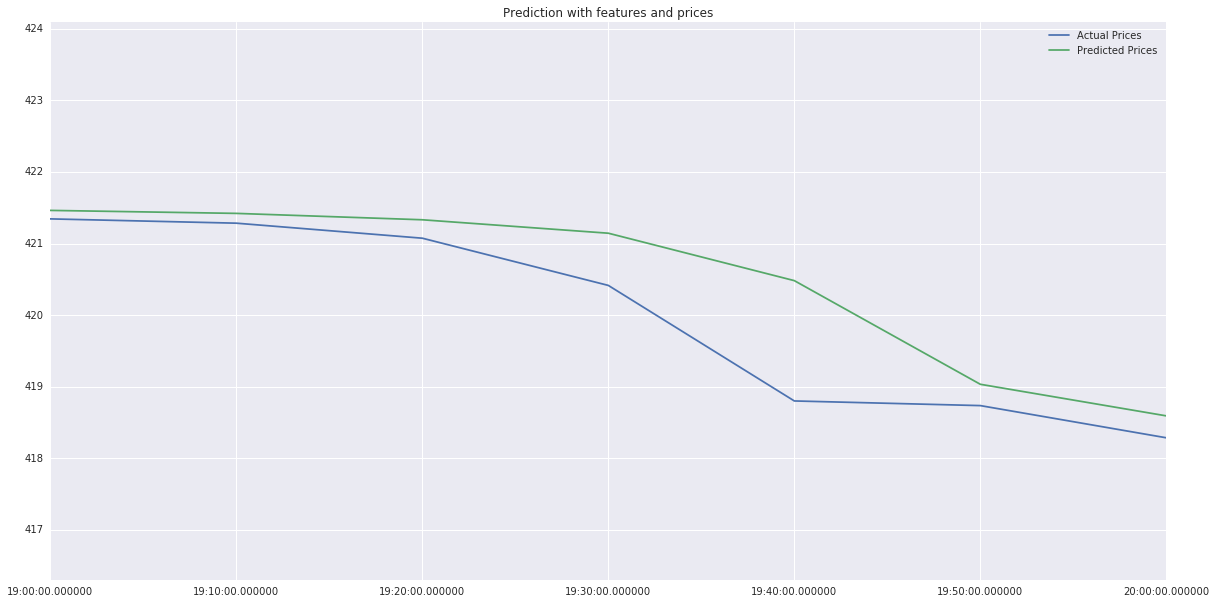

In [10]:
evaluate(datas[4].copy())